# Sequential Data
Sequential Data(순차 데이터)는 데이터의 요소들이 특정한 순서로 정렬되어 있고, 이 순서가 데이터의 의미를 결정하는 데이터 유형이다.

시간, 순서, 위치 등 순차적인 흐름을 따르는 데이터를 포함한다. 일반적으로 자연어 처리, 시계열 분석, 음성 신호 처리, 주식 데이터, 센서 데이터 등 다양한 응용 분야에서 활용된다.

**특징**
1. **순서의 중요성**  
   데이터의 순서가 결과를 결정짓는 데 중요한 역할을 한다. 예를 들어, 텍스트 데이터에서 단어의 순서가 문장의 의미를 결정한다.

2. **시점 정보 포함**  
   데이터가 특정 시점 또는 위치에서 발생한 정보일 경우, 시점 정보가 데이터의 해석에 중요하다.

3. **연속성**  
   데이터가 시간 축이나 공간 축에서 연속적으로 변화하며 상관관계를 가질 수 있다.

**예시**
- Speech recognition: 파동의 연속 → 단어의 연속으로 변환
- Music generation : 연속된 음표 출력
- Sentiment classification: Text → 평점, 부정/긍정 판단
- DNA 분석 : 염기서열 → 질병유무, 단백질 종류 등 atGPT/생성 모델까지)
- 자동 번역: 한국어 → 영어
- Video activity recognition: 연속된 장면 → 행동 판단
- Financial Data: 시계열자료 → 주가, 환율예측 등

**분석 방법**
1. **통계적 분석**  
   - 이동 평균, 분산 분석 등을 통해 시간 또는 순서의 변화 패턴 파악  
   
2. **머신러닝**  
   - Recurrent Neural Network(RNN), Long Short-Term Memory(LSTM), Gated Recurrent Unit(GRU) 등 순차 데이터 학습을 위한 신경망 사용  

3. **트랜스포머 모델**  
   - 자연어 처리 및 시계열 분석에서 효율적으로 순차적 패턴을 학습  
   

# RNN


RNN(Recurrent Neural Network)은 **순차 데이터(Sequential Data)**를 처리하기 위해 설계된 인공 신경망이다. RNN은 입력 데이터의 시간적 순서를 고려하여 정보를 처리하며, 특히 텍스트, 음성, 시계열 데이터 등에서 많이 사용된다.


- **특화**: 시퀀스 데이터 처리에 강점이 있음
- **기억 능력**: 이전 입력을 '기억'하며 처리
  - 네트워크는 입력 데이터를 요약하여 기억을 저장
  - 새로운 입력이 들어올 때마다 기억을 조금씩 수정
  - 모든 입력을 처리한 후, 남은 기억은 시퀀스를 전체적으로 요약하는 정보로 활용
- **반복적 처리**: 입력마다 기억을 갱신하며 순환적으로 진행 (사람이 단어를 기억하며 이해하는 방식과 유사)



**RNN 다양한 입출력 타입**

![](https://d.pr/i/s2J7sK+)

1. **One-to-One**  
   - 입력 데이터 하나에 출력 데이터 하나를 생성하는 구조.  
   - 이미지 분류 (Image Classification)

2. **One-to-Many**  
   - 하나의 입력 데이터를 기반으로 다수의 출력 시퀀스를 생성.  
   -  
     - 이미지로부터 문장 생성 (Image Captioning)  
     - 작곡, 작시  

3. **Many-to-One**  
   - 여러 입력 시퀀스를 받아 하나의 출력 데이터를 생성.  
   -  
     - 감정 분석 (Sentiment Analysis, 예: Positive/Negative)  
     - 스팸 탐지 (Spam Detection)  

4. **Many-to-Many (동일 길이)**  
   - 입력과 출력 시퀀스의 길이가 동일한 구조.  
   -  
     - Video 각 frame에 label 생성  
     - 품사 태깅 (Part-of-Speech Tagging)  
     - 개체명 인식 (Named Entity Recognition)  
     - Character 단위 문장 생성  

5. **Many-to-Many (다른 길이)**  
   - 입력과 출력 시퀀스의 길이가 다를 수 있는 구조.  
   -  
     - 기계 번역 (영어 → 한국어 문장)  
     - 챗봇 (Chatbot)  
     - 질문 응답 (Question Answering)  

  
**RNN 구조 (Unfolding)**

![](https://d.pr/i/w43PfD+)

- RNN을 순서대로 펼쳐놓으면 weight을 공유하는 매우 깊은 신경망이 된다.
- RNN의 오차역전파는 BPTT Backpropagation Through Time)으로 처리된다.


1. **은닉 상태 업데이트**  
   $
   h_t = \tanh(W_h \cdot h_{t-1} + W_x \cdot x_t + b_h)
   $
   - $h_t$: 현재 시점의 은닉 상태  
   - $h_{t-1}$: 이전 시점의 은닉 상태  
   - $x_t$: 현재 입력 데이터  
   - $W_h, W_x, b_h$: 가중치 및 편향  

2. **출력 계산**  
   $
   y_t = W_y \cdot h_t + b_y
   $
   - $y_t$: 현재 시점의 출력  
   - $W_y, b_y$: 출력 가중치 및 편향  


**RNN의 동작 과정**

1. 첫 번째 시점 $t=1$:
   - 입력 $x_1$를 받아 은닉 상태 $h_1$ 계산.
   - 출력 $y_1$ 생성.

2. 두 번째 시점 $t=2$:
   - 이전 은닉 상태 $h_1$와 현재 입력 $x_2$를 사용해 $h_2$ 계산.
   - 출력 $y_2$ 생성.

3. 반복:
   - 다음 시점 $t$에서도 동일한 과정을 반복.

**RNN의 단점**

1. **기울기 소멸 및 폭발 문제**  
   - 역전파 과정에서 기울기가 매우 작아지거나 커져 학습이 어려워진다.  
   - 이 문제를 해결하기 위해 LSTM(Long Short-Term Memory)과 GRU(Gated Recurrent Unit) 같은 변형 구조가 개발되었다.

2. **장기 의존성 문제**  
   - 오래된 과거 정보가 현재 출력에 반영되지 못하는 문제가 발생한다.



**RNN 구현체**
1. **RNN**: 단순 구조, 기울기 소멸 문제 발생.  
2. **LSTM**: 게이트 구조 추가로 장기 의존성을 처리.  
3. **GRU**: LSTM보다 간단한 구조로 비슷한 성능 제공.


**RNN 학습과정**

vocab은 `['h', 'e', 'l', 'o']`일때, one-hot encoding된 입력데이터를 제공하고, 입력에 적절한 출력이 나오는 모델을 훈련시키는 과정
1. h가 입력되면, e가 나와야 한다.
2. e가 제일 큰 예측치를 가지도록 Back Propagation이 일어난다. 이때는 time step을 거슬러 역전파를 수행하므로 이를 특별히 BPTT Back Propagation Through Time이라고 한다.
3. e가 입력되면, l이 나와야 하며, 첫번재 l이 입력되면, l이 나오고, 두번째 l이 입력되면, o가 나와야 한다.
4. 이게 가능한 이유는 e가 입력될때, 은닉상태로 h가 전달되고, 첫번재 l이 입력될때 은닉상태로 he가 전달되고, 두번째 l이 입력될때 hel이 전달되기 때문이다.
5. 다만 RNN의 단기 기억 특성상 직전 기억에 비해 이전 기억은 계속 소실되는 경향이 있다.

![](https://d.pr/i/dnmFIq+)


## RNN 구조

In [ ]:
# RNN 입력/출력 텐서
import torch
import torch.nn as nn

batch_size = 2     # B : 한번에 처리할 샘플(문장) 개수
seq_len = 3        # T : 시퀀스 길이(Time Steps)
input_size = 4     # F : 각 시점의 입력 차원 (vocab_size 또는 임베딩 차원)
hidden_size = 5    # H : RNN의 은닉 상태 차원

x = torch.randn(batch_size, seq_len, input_size)    # 입력 시퀀스 텐서 생성 : (B, T, F)
print(x.shape)

# RNN 생성 ((B, T, F) 형태로 입력을 받도록 설정)
rnn = nn.RNN(input_size, hidden_size, batch_first=True)
output, hidden = rnn(x)    # 순전파 : output(전체 시점 출력), hidden(마지막 은닉)

print(output.shape)    # (B, T, H) : 모든 시점의 은닉 출력들이 쌓인 결과
print(hidden.shape)    # (Num_layers, B, H)  : 마지막 시점 은닉 상태

torch.Size([2, 3, 4])
torch.Size([2, 3, 5])
torch.Size([1, 2, 5])


- Batch_first=True => 입력 (B, T, F), 출력 (B, T, H)
- Batch_first=False => 입력 (T, B, F), 출력 (T, B, H)
- 데이터를 (배치, 시간, 특징) 형태로 쓰고싶으면 Batch_first=True 설정 후 사용한다.

## IMDB 리뷰 감성분석
- IMDB 데이터는 영화 리뷰 텍스트와 그 리뷰의 감성(긍정/부정) 라벨로 구성된 이진 분류용 데이터셋
- 입력(X): 영화 리뷰 문장(원문 텍스트) → `tensorflow.keras.datasets.imdb`로 불러오면 “바로 모델에 넣어 실습할 수 있게” 미리 전처리된 형태(단어→정수 ID)로 제공
- 정답(y): 감성 라벨 0=부정, 1=긍정
- imdb.load_data(num_words=vocab_size)의 의미: 빈도 상위 vocab_size개 단어만 단어사전에 남기고, 나머지는(덜 나온 단어) 잘리거나 OOV로 처리되는 방식

- 결과적으로 **“영화 리뷰가 긍정인지 부정인지 맞추는 감성분류 데이터”**

In [ ]:
from tensorflow.keras.datasets import imdb

vocab_size = 300    # 사용할 단어 사전 크기 (상위 빈도 단어만 유지)

# IMDB 데이터 로드 (단어 ID 시퀀스 형태)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print(X_train.shape, y_train.shape)  # 학습 데이터 개수
print(X_test.shape, y_test.shape)    # 테스트 데이터 개수

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


c:\Users\Playdata\nlp\nlp_venv\Lib\site-packages\numpy\lib\_format_impl.py:838: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  array = pickle.load(fp, **pickle_kwargs)


(25000,) (25000,)
(25000,) (25000,)


In [4]:
# 메모리 사용량 조절 train_size, test_size
train_size = 25000    # 학습 샘플 수
test_size = 10000     # 테스트 샘플 수
X_train = X_train[:train_size]
y_train = y_train[:train_size]
X_test = X_test[:test_size]
y_test = y_test[:test_size]

print(X_train.shape, y_train.shape)  # 학습 데이터 개수
print(X_test.shape, y_test.shape)    # 테스트 데이터 개수

(25000,) (25000,)
(10000,) (10000,)


In [ ]:
print(type(X_train), X_train.shape)        # 학습 입력 데이터의 자료형과 형태
print(type(X_train[0]), len(X_train[0]))   # 첫 번째 샘플의 자료형과 시퀀스 길이

print(X_train[1])
print(len(X_train[1]))    # 두 번째 샘플의 시퀀스 길이
print(y_train[1])         # 두 번째 샘플의 라벨

<class 'numpy.ndarray'> (25000,)
<class 'list'> 218
[1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 2, 8, 118, 2, 14, 2, 20, 13, 119, 2, 189, 102, 5, 207, 110, 2, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2, 2, 5, 2, 4, 116, 9, 35, 2, 4, 229, 9, 2, 2, 4, 118, 9, 4, 130, 2, 19, 4, 2, 5, 89, 29, 2, 46, 37, 4, 2, 9, 45, 43, 38, 2, 2, 2, 4, 2, 26, 2, 5, 163, 11, 2, 2, 4, 2, 9, 194, 2, 7, 2, 2, 2, 2, 148, 2, 2, 2, 15, 123, 125, 68, 2, 2, 15, 2, 165, 2, 98, 5, 4, 228, 9, 43, 2, 2, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 2, 228, 2, 5, 2, 2, 245, 2, 5, 4, 2, 131, 152, 2, 18, 2, 32, 2, 2, 14, 9, 6, 2, 78, 22, 2, 64, 2, 9, 8, 168, 145, 23, 4, 2, 15, 16, 4, 2, 5, 28, 6, 52, 154, 2, 33, 89, 78, 285, 16, 145, 95]
189
0


In [ ]:
import torch                   # PyTorch 핵심 라이브러리
import torch.nn as nn          # 신경망 레이어/모듈 (nn.Module, Linear, RNN 등)
import torch.optim as optim    # 최적화 알고리즘 (Adam 등)

In [10]:
# IMDB 시퀀스/라벨을 PyTorch Tensor로 변환
X_train = [torch.tensor(seq, dtype=torch.long) for seq in X_train]  # 학습 시퀀스(단어 ID 리스트) -> LongTensor로 변환
X_test = [torch.tensor(seq, dtype=torch.long) for seq in X_test]    # 테스트 시퀀스(단어 ID 리스트) -> LongTensor로 변환

y_train = torch.tensor(y_train, dtype=torch.float)    # 학습 라벨(0/1) -> FloatTensor로 변환
y_test = torch.tensor(y_test, dtype=torch.float)      # 테스트 라벨(0/1) -> FloatTensor로 변환

X_train[0], y_train[0]

C:\Users\Playdata\AppData\Local\Temp\ipykernel_15868\131660155.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = [torch.tensor(seq, dtype=torch.long) for seq in X_train]  # 학습 시퀀스(단어 ID 리스트) -> LongTensor로 변환
C:\Users\Playdata\AppData\Local\Temp\ipykernel_15868\131660155.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = [torch.tensor(seq, dtype=torch.long) for seq in X_test]    # 테스트 시퀀스(단어 ID 리스트) -> LongTensor로 변환
C:\Users\Playdata\AppData\Local\Temp\ipykernel_15868\131660155.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sou

(tensor([  1,  14,  22,  16,  43,   2,   2,   2,   2,  65,   2,   2,  66,   2,
           4, 173,  36, 256,   5,  25, 100,  43,   2, 112,  50,   2,   2,   9,
          35,   2, 284,   5, 150,   4, 172, 112, 167,   2,   2,   2,  39,   4,
         172,   2,   2,  17,   2,  38,  13,   2,   4, 192,  50,  16,   6, 147,
           2,  19,  14,  22,   4,   2,   2,   2,   4,  22,  71,  87,  12,  16,
          43,   2,  38,  76,  15,  13,   2,   4,  22,  17,   2,  17,  12,  16,
           2,  18,   2,   5,  62,   2,  12,   8,   2,   8, 106,   5,   4,   2,
           2,  16,   2,  66,   2,  33,   4, 130,  12,  16,  38,   2,   5,  25,
         124,  51,  36, 135,  48,  25,   2,  33,   6,  22,  12, 215,  28,  77,
          52,   5,  14,   2,  16,  82,   2,   8,   4, 107, 117,   2,  15, 256,
           4,   2,   7,   2,   5,   2,  36,  71,  43,   2,   2,  26,   2,   2,
          46,   7,   4,   2,   2,  13, 104,  88,   4,   2,  15, 297,  98,  32,
           2,  56,  26, 141,   6, 194,   2,  18,   4

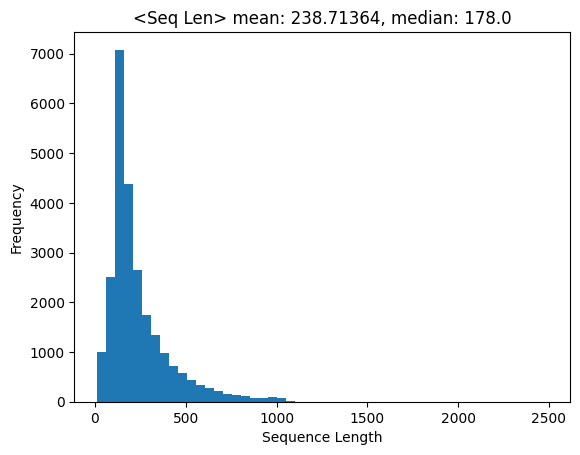

In [12]:
# 패딩 길이 결정을 위한 시퀀스 길이 분포 확인
import matplotlib.pyplot as plt
import numpy as np

X_train_len = [len(seq) for seq in X_train]    # 각 리뷰 샘플 시퀀스 길이를 리스트로 수집

X_train_len_mean = np.mean(X_train_len)        # 시퀀스 길이 평균
X_train_len_median = np.median(X_train_len)    # 시퀀스 길이 중앙값

plt.hist(X_train_len, bins=50)     # 시퀀스 길이 분포를 히스토그램으로 시각화 (구간 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title(f'<Seq Len> mean: {X_train_len_mean}, median: {X_train_len_median}')
plt.show()

히스토그램을 확인하고 max_len(패딩 길이)를 몇으로 할지 결정한다.

In [ ]:
# 시퀀스 패딩 처리로 길이 고정
import torch.nn.functional as F

seq_len = 100    # 고정할 시퀀스 길이 (패딩/자르기 기준)

# 시퀀스들을 max_len 길이로 패딩(0) 또는 자르기하여 텐서로 변환하는 함수
def pad_sequences(sequences, max_len):
    padded_sequences = []        # 패딩 완료된 시퀀스를 모을 리스트
    for seq in sequences:        # 각 샘플(가변 길이 시퀀스) 순회
        if len(seq) < max_len:
            padded_seq = F.pad(seq, (0, max_len-len(seq)), value=0)  # 오른쪽에 0을 채워 길이 맞춤
        else:
            padded_seq = seq[:max_len]    # max_len보다 길면 앞부분 남긴다.

        padded_sequences.append(padded_seq)    # 결과 시퀀스 저장
    
    return torch.stack(padded_sequences)    # 리스트를 (N, max_len) 텐서로 스택

X_train_padded = pad_sequences(X_train, seq_len)    # 학습 데이터 시퀀스 길이 고정
X_test_padded = pad_sequences(X_test, seq_len)      # 테스트 데이터 시퀀스 길이 고정

X_train_padded.shape, X_test_padded.shape    # (샘플 수, seq_len) 형태

(torch.Size([25000, 100]), torch.Size([10000, 100]))

In [ ]:
# torch.stack() 동작
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
c = torch.tensor([7, 8, 9])

print([a, b, c])                # 텐서 3개가 들어있는 파이썬 리스트
print(torch.stack([a, b, c]))   # 새로운 차원으로 쌓아 2차원 텐서로 변환

[tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9])]
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


torch.stack은 텐서들을 새 축(차원)으로 쌓아서 [3] -> [[3], [3], [3]]처럼 shape이 늘어난다.

In [ ]:
# 패딩 전/후 시퀀스 비교
print(X_train[1])           # 원본 2번째 샘플의 시퀀스
print(X_train_padded[1])    # 패딩/자르기 후 2번째 샘플의 시퀀스

tensor([  1, 194,   2, 194,   2,  78, 228,   5,   6,   2,   2,   2, 134,  26,
          4,   2,   8, 118,   2,  14,   2,  20,  13, 119,   2, 189, 102,   5,
        207, 110,   2,  21,  14,  69, 188,   8,  30,  23,   7,   4, 249, 126,
         93,   4, 114,   9,   2,   2,   5,   2,   4, 116,   9,  35,   2,   4,
        229,   9,   2,   2,   4, 118,   9,   4, 130,   2,  19,   4,   2,   5,
         89,  29,   2,  46,  37,   4,   2,   9,  45,  43,  38,   2,   2,   2,
          4,   2,  26,   2,   5, 163,  11,   2,   2,   4,   2,   9, 194,   2,
          7,   2,   2,   2,   2, 148,   2,   2,   2,  15, 123, 125,  68,   2,
          2,  15,   2, 165,   2,  98,   5,   4, 228,   9,  43,   2,   2,  15,
        299, 120,   5, 120, 174,  11, 220, 175, 136,  50,   9,   2, 228,   2,
          5,   2,   2, 245,   2,   5,   4,   2, 131, 152,   2,  18,   2,  32,
          2,   2,  14,   9,   6,   2,  78,  22,   2,  64,   2,   9,   8, 168,
        145,  23,   4,   2,  15,  16,   4,   2,   5,  28,   6,  

In [ ]:
# 원-핫 인코딩으로 단어 ID를 벡터로 변환
X_train_onehot = F.one_hot(X_train_padded, num_classes=vocab_size)  # (N, seq_len) ID -> (N, seq_len, vocab_size) 원-핫
X_test_onehot = F.one_hot(X_test_padded, num_classes=vocab_size)    # 테스트 데이터 동일

X_train_onehot.shape, X_test_onehot.shape

(torch.Size([25000, 100, 300]), torch.Size([10000, 100, 300]))

shape이 (샘플 수, seq_len, vocab_size)로 커지면서 메모리 사용량이 크게 늘어난다.

In [21]:
# IMDB 감성분류 RNN 모델
class IMDBSentimentRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()               # nn.Module 초기화
        self.rnn = nn.RNN(
            input_size = input_dim,     # 입력 feature 차원 (원-핫이면 vocab_size)
            hidden_size = hidden_dim,   # 은닉 상태 차원
            batch_first = True          # 입력 shape이 (B, T, F) 형태
        )
        self.fc = nn.Linear(hidden_dim, output_dim)    # 마지막 hidden -> 출력(logit) 변환
    
    def forward(self, x):
        output, hidden = self.rnn(x)           # output : (B, T, H), hidden: (1, B, H)
        output = self.fc(hidden.squeeze(0))    # hidden에서 layer 축 제거 -> (B, H) 후 fc 적용
        return output                          # (B, output_dim) 반환       

input_dim = vocab_size    # 원-핫 인코딩 feature 차원 = vocab_size
hidden_dim = 8            # RNN 은닉차원 수
output_dim = 1            # 이진 분류 출력(logit 1개)

model = IMDBSentimentRNN(input_dim, hidden_dim, output_dim)
model

IMDBSentimentRNN(
  (rnn): RNN(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
# RNN 모델 파라미터(가중치/편향) 이름과 shape 확인
for name, param in model.named_parameters():
    print(name, param.shape)    # 파라미터 이름과 텐서 shape 출력

rnn.weight_ih_l0 torch.Size([8, 300])
rnn.weight_hh_l0 torch.Size([8, 8])
rnn.bias_ih_l0 torch.Size([8])
rnn.bias_hh_l0 torch.Size([8])
fc.weight torch.Size([1, 8])
fc.bias torch.Size([1])


In [ ]:
# torchinfo로 모델 요약(summary) 확인
from torchinfo import summary

summary(model)  # 모델 레이어별 shape/파라미터 수 요약 출력

Layer (type:depth-idx)                   Param #
IMDBSentimentRNN                         --
├─RNN: 1-1                               2,480
├─Linear: 1-2                            9
Total params: 2,489
Trainable params: 2,489
Non-trainable params: 0

summary(model) : 각 레이어의 출력 shape과 파라미터 수를 확인

In [24]:
# 출력 라벨을 2차원 텐서로 변환
y_train = y_train.unsqueeze(1)    # (N,) -> (N, 1)로 차원 추가
y_test = y_test.unsqueeze(1)      # (N,) -> (N, 1)로 차원 추가

y_train.shape, y_test.shape

(torch.Size([25000, 1]), torch.Size([10000, 1]))

In [ ]:
# 학습/검증 데이터 분리 및 DataLoader 구성
from torch.utils.data import random_split, DataLoader, TensorDataset

batch_size = 64                                # 미니배치 크기
train_size = int(len(X_train_onehot) * 0.8)    # 학습 데이터 개수 (80%)
val_size = len(X_train_onehot) - train_size    # 검증 데이터 개수 (20%)

# 학슴/검증 데이터셋 분리
train_dataset, val_dataset = random_split(TensorDataset(X_train_onehot, y_train), [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 학습용 : 섞어서 배치 생성
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)     # 검증용 : 순서 유지

- random_split(TensorDataset(X_train_onehot, y_train), [train_size, val_size])
    - TensorDataset(X_train_onehot, y_train) : X_train_onehot[i], y_train[i]를 한쌍으로 꺼내게 해주는 Dataset (샘플단위로 묶음)
    - random_split(dataset, [train_size, val_size]) : Dataset을 인덱스를 랜덤으로 섞어서 train_size(크기) 부분 + val_size(크기) 부분으로 나눔.
        - 반환값은 (train_dataset, val_dataset) 두개의 Subset 객체
    - 결과적으로는 (X, y) 쌍으로 묶인 학습 데이터를 무작위로 "train, val" 덩어리로 나눈다.

In [26]:
# CUDA 사용 가능 여부
torch.cuda.is_available()

False

In [29]:
from tqdm import tqdm

# GPU 활용 가능시 GPU 기반으로 RNN 학습 루프 (BCEWithLogits + Adam + Early Stopping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

# 메모리 캐시 정리
torch.cuda.empty_cache()

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()                       # 이진분류 손실 (시그모이드 포함 logit 입력용)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 100

# 시각화를 위한 loss 기록
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련
early_stopping_patience = 20
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in tqdm(range(epochs)):
    total_loss, correct, total = 0, 0, 0    # 누적 손실, 정답, 전체 샘플 수

    model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()

        optimizer.zero_grad()               # 이전 배치 기울기 초기화
        output = model(inputs)              # 순전파
        loss = criterion(output, labels)    # 손실 계산
        loss.backward()                     # 역전파
        optimizer.step()                    # 파라미터 업데이트

        # 배치 로그
        total_loss += loss.item()    # 배치 손실을 스칼라로 누적
        p = torch.sigmoid(output)    # logit -> 0~1 확률로 변환
        pred = (p >= 0.5).float()
        correct += (pred == labels).sum().item()  # 맞춘 개수
        total += labels.size(0)                   # 배치 샘플 수
    
    # 에폭 로그
    train_loss = total_loss / len(train_dataloader)  # 에폭별 평균 학습 손실
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accs.append(train_acc)

    # 검증
    model.eval()                                # 평가 모드 (Dropout, BN 비활성화)
    val_loss, val_correct, val_total = 0, 0, 0  # 누적 손실, 정답, 전체 샘플 수
    with torch.no_grad():                       # 기울기 계산 비활성화
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device).float()
        
            output = model(val_inputs)
            loss = criterion(output, val_labels)
            
            # 배치 로그
            val_loss += loss.item()
            p = torch.sigmoid(output)
            pred = (p >= 0.5).float()
            val_correct += (pred == val_labels).sum().item()
            val_total += val_labels.size(0)
        
        # 에폭 로그
        val_loss = val_loss / len(val_dataloader)
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)

        # 에폭 로그 출력
        print(f"Epoch {epoch +1}/{epochs}: Train Loss {train_loss:.4f} Train Acc {train_acc:.4f} Val loss {val_loss:.4f} Val Acc {val_acc:.4f}")

        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopped at Epoch {epoch +1}")
                break

device cpu


  1%|          | 1/100 [00:04<07:00,  4.24s/it]

Epoch 1/100: Train Loss 0.6927 Train Acc 0.5137 Val loss 0.6931 Val Acc 0.5086


  2%|▏         | 2/100 [00:08<06:55,  4.24s/it]

Epoch 2/100: Train Loss 0.6924 Train Acc 0.5192 Val loss 0.6929 Val Acc 0.5098


  3%|▎         | 3/100 [00:12<06:52,  4.25s/it]

Epoch 3/100: Train Loss 0.6921 Train Acc 0.5200 Val loss 0.6927 Val Acc 0.5084


  4%|▍         | 4/100 [00:17<07:20,  4.59s/it]

Epoch 4/100: Train Loss 0.6918 Train Acc 0.5234 Val loss 0.6926 Val Acc 0.5092


  5%|▌         | 5/100 [00:23<07:41,  4.85s/it]

Epoch 5/100: Train Loss 0.6915 Train Acc 0.5239 Val loss 0.6924 Val Acc 0.5126


  6%|▌         | 6/100 [00:28<07:52,  5.02s/it]

Epoch 6/100: Train Loss 0.6913 Train Acc 0.5249 Val loss 0.6923 Val Acc 0.5130


  7%|▋         | 7/100 [00:34<08:04,  5.20s/it]

Epoch 7/100: Train Loss 0.6910 Train Acc 0.5265 Val loss 0.6921 Val Acc 0.5138


  8%|▊         | 8/100 [00:39<08:01,  5.23s/it]

Epoch 8/100: Train Loss 0.6907 Train Acc 0.5279 Val loss 0.6920 Val Acc 0.5158


  9%|▉         | 9/100 [00:44<08:04,  5.33s/it]

Epoch 9/100: Train Loss 0.6904 Train Acc 0.5315 Val loss 0.6918 Val Acc 0.5170


 10%|█         | 10/100 [00:50<08:01,  5.35s/it]

Epoch 10/100: Train Loss 0.6900 Train Acc 0.5308 Val loss 0.6916 Val Acc 0.5202


 11%|█         | 11/100 [00:55<07:59,  5.38s/it]

Epoch 11/100: Train Loss 0.6897 Train Acc 0.5330 Val loss 0.6915 Val Acc 0.5216


 12%|█▏        | 12/100 [01:01<07:52,  5.37s/it]

Epoch 12/100: Train Loss 0.6892 Train Acc 0.5371 Val loss 0.6912 Val Acc 0.5256


 13%|█▎        | 13/100 [01:06<07:44,  5.34s/it]

Epoch 13/100: Train Loss 0.6887 Train Acc 0.5400 Val loss 0.6910 Val Acc 0.5270


 14%|█▍        | 14/100 [01:11<07:34,  5.28s/it]

Epoch 14/100: Train Loss 0.6882 Train Acc 0.5445 Val loss 0.6905 Val Acc 0.5304


 15%|█▌        | 15/100 [01:16<07:25,  5.24s/it]

Epoch 15/100: Train Loss 0.6872 Train Acc 0.5481 Val loss 0.6898 Val Acc 0.5328


 16%|█▌        | 16/100 [01:21<07:14,  5.18s/it]

Epoch 16/100: Train Loss 0.6855 Train Acc 0.5565 Val loss 0.6879 Val Acc 0.5438


 17%|█▋        | 17/100 [01:26<07:11,  5.20s/it]

Epoch 17/100: Train Loss 0.6803 Train Acc 0.5722 Val loss 0.6767 Val Acc 0.5866


 18%|█▊        | 18/100 [01:32<07:02,  5.16s/it]

Epoch 18/100: Train Loss 0.6726 Train Acc 0.5914 Val loss 0.6753 Val Acc 0.5888


 19%|█▉        | 19/100 [01:36<06:50,  5.06s/it]

Epoch 19/100: Train Loss 0.6700 Train Acc 0.5964 Val loss 0.6695 Val Acc 0.6028


 20%|██        | 20/100 [01:41<06:45,  5.07s/it]

Epoch 20/100: Train Loss 0.6657 Train Acc 0.6042 Val loss 0.6644 Val Acc 0.6130


 21%|██        | 21/100 [01:46<06:36,  5.03s/it]

Epoch 21/100: Train Loss 0.6622 Train Acc 0.6129 Val loss 0.6610 Val Acc 0.6138


 22%|██▏       | 22/100 [01:51<06:27,  4.96s/it]

Epoch 22/100: Train Loss 0.6573 Train Acc 0.6212 Val loss 0.6546 Val Acc 0.6292


 23%|██▎       | 23/100 [01:56<06:16,  4.89s/it]

Epoch 23/100: Train Loss 0.6556 Train Acc 0.6232 Val loss 0.6515 Val Acc 0.6334


 24%|██▍       | 24/100 [02:01<06:04,  4.80s/it]

Epoch 24/100: Train Loss 0.6518 Train Acc 0.6297 Val loss 0.6495 Val Acc 0.6374


 25%|██▌       | 25/100 [02:05<06:00,  4.81s/it]

Epoch 25/100: Train Loss 0.6494 Train Acc 0.6324 Val loss 0.6490 Val Acc 0.6398


 26%|██▌       | 26/100 [02:10<05:58,  4.85s/it]

Epoch 26/100: Train Loss 0.6480 Train Acc 0.6360 Val loss 0.6454 Val Acc 0.6450


 27%|██▋       | 27/100 [02:15<05:55,  4.86s/it]

Epoch 27/100: Train Loss 0.6438 Train Acc 0.6438 Val loss 0.6510 Val Acc 0.6302


 28%|██▊       | 28/100 [02:20<05:50,  4.87s/it]

Epoch 28/100: Train Loss 0.6447 Train Acc 0.6410 Val loss 0.6432 Val Acc 0.6450


 29%|██▉       | 29/100 [02:25<05:51,  4.95s/it]

Epoch 29/100: Train Loss 0.6398 Train Acc 0.6475 Val loss 0.6387 Val Acc 0.6566


 30%|███       | 30/100 [02:31<05:58,  5.12s/it]

Epoch 30/100: Train Loss 0.6373 Train Acc 0.6515 Val loss 0.6474 Val Acc 0.6354


 31%|███       | 31/100 [02:36<06:02,  5.26s/it]

Epoch 31/100: Train Loss 0.6339 Train Acc 0.6564 Val loss 0.6353 Val Acc 0.6594


 32%|███▏      | 32/100 [02:41<05:51,  5.16s/it]

Epoch 32/100: Train Loss 0.6321 Train Acc 0.6587 Val loss 0.6339 Val Acc 0.6608


 33%|███▎      | 33/100 [02:46<05:46,  5.17s/it]

Epoch 33/100: Train Loss 0.6302 Train Acc 0.6603 Val loss 0.6361 Val Acc 0.6520


 34%|███▍      | 34/100 [02:51<05:37,  5.11s/it]

Epoch 34/100: Train Loss 0.6273 Train Acc 0.6655 Val loss 0.6330 Val Acc 0.6552


 35%|███▌      | 35/100 [02:56<05:30,  5.09s/it]

Epoch 35/100: Train Loss 0.6270 Train Acc 0.6654 Val loss 0.6380 Val Acc 0.6534


 36%|███▌      | 36/100 [03:01<05:21,  5.03s/it]

Epoch 36/100: Train Loss 0.6250 Train Acc 0.6673 Val loss 0.6363 Val Acc 0.6480


 37%|███▋      | 37/100 [03:07<05:23,  5.13s/it]

Epoch 37/100: Train Loss 0.6230 Train Acc 0.6696 Val loss 0.6280 Val Acc 0.6644


 38%|███▊      | 38/100 [03:11<05:11,  5.03s/it]

Epoch 38/100: Train Loss 0.6211 Train Acc 0.6706 Val loss 0.6265 Val Acc 0.6660


 39%|███▉      | 39/100 [03:16<05:04,  5.00s/it]

Epoch 39/100: Train Loss 0.6175 Train Acc 0.6768 Val loss 0.6233 Val Acc 0.6672


 40%|████      | 40/100 [03:21<04:57,  4.96s/it]

Epoch 40/100: Train Loss 0.6166 Train Acc 0.6782 Val loss 0.6206 Val Acc 0.6732


 41%|████      | 41/100 [03:26<04:48,  4.90s/it]

Epoch 41/100: Train Loss 0.6137 Train Acc 0.6828 Val loss 0.6219 Val Acc 0.6668


 42%|████▏     | 42/100 [03:31<04:47,  4.95s/it]

Epoch 42/100: Train Loss 0.6130 Train Acc 0.6809 Val loss 0.6189 Val Acc 0.6722


 43%|████▎     | 43/100 [03:36<04:37,  4.87s/it]

Epoch 43/100: Train Loss 0.6103 Train Acc 0.6839 Val loss 0.6243 Val Acc 0.6628


 44%|████▍     | 44/100 [03:41<04:37,  4.95s/it]

Epoch 44/100: Train Loss 0.6081 Train Acc 0.6874 Val loss 0.6142 Val Acc 0.6806


 45%|████▌     | 45/100 [03:46<04:35,  5.01s/it]

Epoch 45/100: Train Loss 0.6061 Train Acc 0.6899 Val loss 0.6158 Val Acc 0.6732


 46%|████▌     | 46/100 [03:51<04:27,  4.96s/it]

Epoch 46/100: Train Loss 0.6044 Train Acc 0.6924 Val loss 0.6127 Val Acc 0.6812


 47%|████▋     | 47/100 [03:56<04:25,  5.02s/it]

Epoch 47/100: Train Loss 0.6035 Train Acc 0.6923 Val loss 0.6152 Val Acc 0.6730


 48%|████▊     | 48/100 [04:01<04:25,  5.11s/it]

Epoch 48/100: Train Loss 0.6013 Train Acc 0.6935 Val loss 0.6138 Val Acc 0.6744


 49%|████▉     | 49/100 [04:07<04:25,  5.21s/it]

Epoch 49/100: Train Loss 0.6015 Train Acc 0.6927 Val loss 0.6083 Val Acc 0.6898


 50%|█████     | 50/100 [04:12<04:18,  5.17s/it]

Epoch 50/100: Train Loss 0.5995 Train Acc 0.6967 Val loss 0.6126 Val Acc 0.6772


 51%|█████     | 51/100 [04:17<04:12,  5.15s/it]

Epoch 51/100: Train Loss 0.5975 Train Acc 0.6994 Val loss 0.6070 Val Acc 0.6880


 52%|█████▏    | 52/100 [04:22<04:10,  5.21s/it]

Epoch 52/100: Train Loss 0.5959 Train Acc 0.7006 Val loss 0.6048 Val Acc 0.6898


 53%|█████▎    | 53/100 [04:27<04:01,  5.13s/it]

Epoch 53/100: Train Loss 0.5954 Train Acc 0.7010 Val loss 0.6131 Val Acc 0.6782


 54%|█████▍    | 54/100 [04:32<03:55,  5.12s/it]

Epoch 54/100: Train Loss 0.5952 Train Acc 0.6994 Val loss 0.6029 Val Acc 0.6920


 55%|█████▌    | 55/100 [04:37<03:48,  5.09s/it]

Epoch 55/100: Train Loss 0.5920 Train Acc 0.7053 Val loss 0.6025 Val Acc 0.6940


 56%|█████▌    | 56/100 [04:43<03:43,  5.09s/it]

Epoch 56/100: Train Loss 0.5904 Train Acc 0.7066 Val loss 0.6013 Val Acc 0.6946


 57%|█████▋    | 57/100 [04:47<03:33,  4.96s/it]

Epoch 57/100: Train Loss 0.5896 Train Acc 0.7067 Val loss 0.6021 Val Acc 0.6908


 58%|█████▊    | 58/100 [04:53<03:36,  5.17s/it]

Epoch 58/100: Train Loss 0.5883 Train Acc 0.7076 Val loss 0.6003 Val Acc 0.6940


 59%|█████▉    | 59/100 [04:59<03:39,  5.36s/it]

Epoch 59/100: Train Loss 0.5873 Train Acc 0.7091 Val loss 0.5992 Val Acc 0.6940


 60%|██████    | 60/100 [05:04<03:35,  5.38s/it]

Epoch 60/100: Train Loss 0.5863 Train Acc 0.7091 Val loss 0.6048 Val Acc 0.6892


 61%|██████    | 61/100 [05:10<03:34,  5.50s/it]

Epoch 61/100: Train Loss 0.5855 Train Acc 0.7096 Val loss 0.5968 Val Acc 0.6982


 62%|██████▏   | 62/100 [05:15<03:25,  5.40s/it]

Epoch 62/100: Train Loss 0.5841 Train Acc 0.7117 Val loss 0.5964 Val Acc 0.6980


 63%|██████▎   | 63/100 [05:20<03:12,  5.19s/it]

Epoch 63/100: Train Loss 0.5842 Train Acc 0.7128 Val loss 0.5997 Val Acc 0.6964


 64%|██████▍   | 64/100 [05:25<03:04,  5.14s/it]

Epoch 64/100: Train Loss 0.5815 Train Acc 0.7140 Val loss 0.5983 Val Acc 0.6960


 65%|██████▌   | 65/100 [05:30<03:04,  5.27s/it]

Epoch 65/100: Train Loss 0.5808 Train Acc 0.7138 Val loss 0.5950 Val Acc 0.6994


 66%|██████▌   | 66/100 [05:35<02:58,  5.24s/it]

Epoch 66/100: Train Loss 0.5795 Train Acc 0.7158 Val loss 0.5934 Val Acc 0.6984


 67%|██████▋   | 67/100 [05:40<02:50,  5.15s/it]

Epoch 67/100: Train Loss 0.5793 Train Acc 0.7149 Val loss 0.6052 Val Acc 0.6868


 68%|██████▊   | 68/100 [05:46<02:47,  5.23s/it]

Epoch 68/100: Train Loss 0.5774 Train Acc 0.7169 Val loss 0.5932 Val Acc 0.6996


 69%|██████▉   | 69/100 [05:52<02:48,  5.43s/it]

Epoch 69/100: Train Loss 0.5772 Train Acc 0.7173 Val loss 0.5924 Val Acc 0.6988


 70%|███████   | 70/100 [05:57<02:38,  5.27s/it]

Epoch 70/100: Train Loss 0.5766 Train Acc 0.7187 Val loss 0.5920 Val Acc 0.7008


 71%|███████   | 71/100 [06:02<02:29,  5.16s/it]

Epoch 71/100: Train Loss 0.5758 Train Acc 0.7199 Val loss 0.5944 Val Acc 0.7016


 72%|███████▏  | 72/100 [06:07<02:23,  5.13s/it]

Epoch 72/100: Train Loss 0.5745 Train Acc 0.7202 Val loss 0.5916 Val Acc 0.6992


 73%|███████▎  | 73/100 [06:11<02:16,  5.04s/it]

Epoch 73/100: Train Loss 0.5738 Train Acc 0.7198 Val loss 0.5906 Val Acc 0.6998


 74%|███████▍  | 74/100 [06:16<02:10,  5.01s/it]

Epoch 74/100: Train Loss 0.5731 Train Acc 0.7201 Val loss 0.5920 Val Acc 0.6996


 75%|███████▌  | 75/100 [06:22<02:08,  5.12s/it]

Epoch 75/100: Train Loss 0.5725 Train Acc 0.7223 Val loss 0.5921 Val Acc 0.7000


 76%|███████▌  | 76/100 [06:27<02:01,  5.05s/it]

Epoch 76/100: Train Loss 0.5728 Train Acc 0.7200 Val loss 0.5948 Val Acc 0.6992


 77%|███████▋  | 77/100 [06:32<02:00,  5.24s/it]

Epoch 77/100: Train Loss 0.5714 Train Acc 0.7229 Val loss 0.5897 Val Acc 0.7012


 78%|███████▊  | 78/100 [06:38<01:55,  5.26s/it]

Epoch 78/100: Train Loss 0.5713 Train Acc 0.7217 Val loss 0.5893 Val Acc 0.7030


 79%|███████▉  | 79/100 [06:43<01:48,  5.19s/it]

Epoch 79/100: Train Loss 0.5704 Train Acc 0.7235 Val loss 0.5887 Val Acc 0.7008


 80%|████████  | 80/100 [06:48<01:44,  5.22s/it]

Epoch 80/100: Train Loss 0.5700 Train Acc 0.7220 Val loss 0.5886 Val Acc 0.7028


 81%|████████  | 81/100 [06:53<01:37,  5.14s/it]

Epoch 81/100: Train Loss 0.5688 Train Acc 0.7257 Val loss 0.5901 Val Acc 0.7030


 82%|████████▏ | 82/100 [06:58<01:32,  5.17s/it]

Epoch 82/100: Train Loss 0.5683 Train Acc 0.7244 Val loss 0.5893 Val Acc 0.7024


 83%|████████▎ | 83/100 [07:04<01:29,  5.25s/it]

Epoch 83/100: Train Loss 0.5704 Train Acc 0.7232 Val loss 0.5957 Val Acc 0.7002


 84%|████████▍ | 84/100 [07:09<01:22,  5.18s/it]

Epoch 84/100: Train Loss 0.5682 Train Acc 0.7248 Val loss 0.5890 Val Acc 0.7016


 85%|████████▌ | 85/100 [07:14<01:17,  5.18s/it]

Epoch 85/100: Train Loss 0.5668 Train Acc 0.7260 Val loss 0.5886 Val Acc 0.7018


 86%|████████▌ | 86/100 [07:19<01:11,  5.11s/it]

Epoch 86/100: Train Loss 0.5670 Train Acc 0.7260 Val loss 0.5875 Val Acc 0.7026


 87%|████████▋ | 87/100 [07:24<01:06,  5.09s/it]

Epoch 87/100: Train Loss 0.5671 Train Acc 0.7240 Val loss 0.5877 Val Acc 0.7042


 88%|████████▊ | 88/100 [07:29<01:00,  5.01s/it]

Epoch 88/100: Train Loss 0.5659 Train Acc 0.7278 Val loss 0.5930 Val Acc 0.7018


 89%|████████▉ | 89/100 [07:33<00:54,  4.95s/it]

Epoch 89/100: Train Loss 0.5651 Train Acc 0.7272 Val loss 0.5848 Val Acc 0.7076


 90%|█████████ | 90/100 [07:38<00:49,  4.94s/it]

Epoch 90/100: Train Loss 0.5647 Train Acc 0.7268 Val loss 0.5866 Val Acc 0.7056


 91%|█████████ | 91/100 [07:43<00:44,  4.96s/it]

Epoch 91/100: Train Loss 0.5638 Train Acc 0.7288 Val loss 0.5849 Val Acc 0.7068


 92%|█████████▏| 92/100 [07:48<00:39,  4.96s/it]

Epoch 92/100: Train Loss 0.5637 Train Acc 0.7283 Val loss 0.5886 Val Acc 0.7052


 93%|█████████▎| 93/100 [07:54<00:36,  5.15s/it]

Epoch 93/100: Train Loss 0.5639 Train Acc 0.7285 Val loss 0.5842 Val Acc 0.7078


 94%|█████████▍| 94/100 [07:59<00:31,  5.22s/it]

Epoch 94/100: Train Loss 0.5623 Train Acc 0.7298 Val loss 0.5852 Val Acc 0.7080


 95%|█████████▌| 95/100 [08:05<00:26,  5.37s/it]

Epoch 95/100: Train Loss 0.5626 Train Acc 0.7296 Val loss 0.5845 Val Acc 0.7088


 96%|█████████▌| 96/100 [08:10<00:21,  5.35s/it]

Epoch 96/100: Train Loss 0.5619 Train Acc 0.7300 Val loss 0.5887 Val Acc 0.7062


 97%|█████████▋| 97/100 [08:15<00:15,  5.32s/it]

Epoch 97/100: Train Loss 0.5624 Train Acc 0.7291 Val loss 0.5851 Val Acc 0.7078


 98%|█████████▊| 98/100 [08:21<00:10,  5.24s/it]

Epoch 98/100: Train Loss 0.5607 Train Acc 0.7320 Val loss 0.5853 Val Acc 0.7070


 99%|█████████▉| 99/100 [08:26<00:05,  5.32s/it]

Epoch 99/100: Train Loss 0.5607 Train Acc 0.7304 Val loss 0.5839 Val Acc 0.7076


100%|██████████| 100/100 [08:32<00:00,  5.12s/it]

Epoch 100/100: Train Loss 0.5600 Train Acc 0.7306 Val loss 0.5848 Val Acc 0.7082


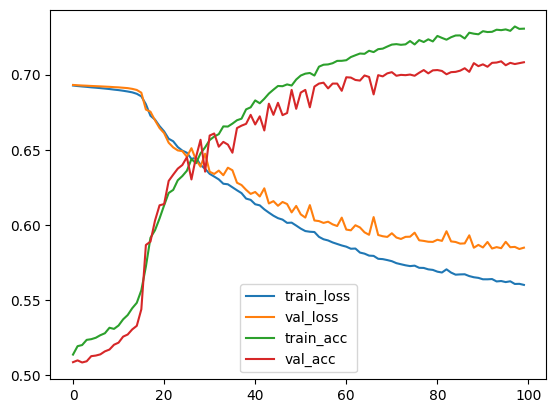

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})

df.plot()     # DataFrame 컬럼들을 한번에 라인 플롯으로 시각화
plt.show()

train, val의 acc, loss 곡선의 간격으로 과적합 여부나 학습 안정성 등을 확인

In [31]:
# 테스트 데이터 모델 성능 평가 함수 및 실행
def evaluate_model(model, test_dataloader, criterion, device):
    model.to(device).eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_inputs, test_labels = test_inputs.to(device).float(), test_labels.to(device).float()

            output = model(test_inputs)
            loss = criterion(output, test_labels)
            
            # 배치 로그
            test_loss += loss.item()
            p = torch.sigmoid(output)
            pred = (p >= 0.5).float()
            test_correct += (pred == test_labels).sum().item()
            test_total += test_labels.size(0)
        
        test_loss = test_loss / len(test_dataloader)
        test_acc = test_correct / test_total
        
        return test_loss, test_acc

test_dataset = TensorDataset(X_test_onehot, y_test)    # 테스트 입력/라벨을 하나의 DataSet으로 묶음
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_loss, test_acc = evaluate_model(model, test_dataloader, criterion, device)
print(f"Test Loss {test_loss}, Test Acc {test_acc}")

Test Loss 0.5902150045534608, Test Acc 0.7038
